In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

file_path1 = '/content/vcf1_filtered.txt'  # 첫 번째 파일 경로
data1 = pd.read_csv(file_path1, sep='\t', header=None, names=['Chromosome', 'Position', 'Score'])

file_path2 = '/content/vcf2_filtered.txt'  # 두 번째 파일 경로
data2 = pd.read_csv(file_path2, sep='\t', header=None, names=['Chromosome', 'Position', 'Score'])

def extract_numeric_score(value):
    if isinstance(value, str):
        match = re.search(r"\((\d+\.\d+|\d+)\)", value)
        if match:
            return float(match.group(1))
    return None

data2['Score'] = data2['Score'].apply(extract_numeric_score)

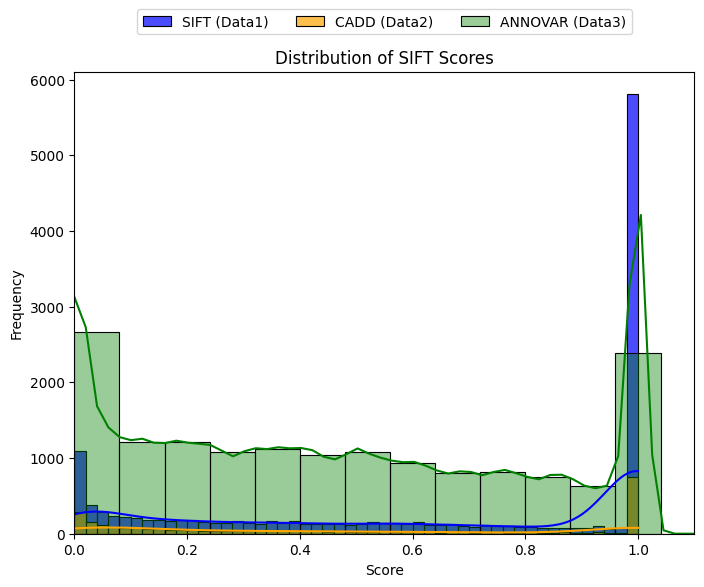

In [5]:
# 첫 번째 데이터 읽기
file_path1 = '/content/vcf1_filtered.txt'  # 첫 번째 파일 경로
data1 = pd.read_csv(file_path1, sep='\t', header=None, names=['Chromosome', 'Position', 'Score'])

# 두 번째 데이터 읽기
file_path2 = '/content/vcf2_filtered.txt'  # 두 번째 파일 경로
data2 = pd.read_csv(file_path2, sep='\t', header=None, names=['Chromosome', 'Position', 'Score'])

# 세 번째 데이터 읽기 (SIFT 점수)
df = pd.read_csv('filtered_annovar_to_sift.csv', sep='\t', on_bad_lines='skip')
df = df[['SIFT_score']]
df['SIFT_score'] = pd.to_numeric(df['SIFT_score'], errors='coerce')
df = df.dropna(subset=['SIFT_score'])
sift_scores = df['SIFT_score']

# CADD 점수에서 숫자 추출
def extract_numeric_score(value):
    if isinstance(value, str):
        match = re.search(r"\((\d+\.\d+|\d+)\)", value)
        if match:
            return float(match.group(1))
    return None

data2['Score'] = data2['Score'].apply(extract_numeric_score)

# 히스토그램 비교 (SIFT, CADD, SIFT_score)
plt.figure(figsize=(8, 6))

# 첫 번째 데이터 (SIFT) 히스토그램
sns.histplot(data1['Score'], bins=50, kde=True, color='blue', label='SIFT (Data1)', alpha=0.7)

# 두 번째 데이터 (CADD) 히스토그램
sns.histplot(data2['Score'], bins=50, kde=True, color='orange', label='CADD (Data2)', alpha=0.7)

# 세 번째 데이터 (SIFT_score) 히스토그램
sns.histplot(sift_scores, bins=50, kde=True, color='green', label='ANNOVAR (Data3)', alpha=0.4, kde_kws={'bw_adjust': 0.3})

plt.xlim(0, 1.1)

plt.title('Distribution of SIFT Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=3)

plt.show()

In [ ]:
import pandas as pd

# CSV 파일 읽기 (첫 번째 데이터셋)
df_csv = pd.read_csv('filtered_annovar_to_sift.csv', sep='\t', on_bad_lines='skip')

# 'SIFT_PREDICTION' 열에서 'D' (deleterious)인 행만 필터링
df_deleterious_csv = df_csv[df_csv['SIFT_pred'] == 'D']

# 'SIFT_score' 열을 숫자형으로 변환
df_deleterious_csv.loc[:, 'SIFT_score'] = pd.to_numeric(df_deleterious_csv['SIFT_score'], errors='coerce')

# NaN 값을 제거한 후 SIFT 점수 추출
sift_scores_csv = df_deleterious_csv['SIFT_score'].dropna()

# 각 SIFT_score 값의 빈도수 카운트
sift_score_counts_csv = sift_scores_csv.value_counts().sort_index()

# 결과를 DataFrame으로 변환
sift_score_df_csv = sift_score_counts_csv.reset_index()
sift_score_df_csv.columns = ['SIFT_score', 'count_ANNO']

# Excel 파일 읽기 (두 번째 데이터셋)
file_path_excel = 'P1300NJS_F_SIFTannotations.xlsx'
df_excel = pd.read_excel(file_path_excel, engine='openpyxl')

# 'SIFT_PREDICTION' 열에서 'DELETERIOUS'인 행만 필터링
deleterious_df_excel = df_excel[df_excel['SIFT_PREDICTION'] == 'DELETERIOUS']

# 'SIFT_SCORE' 열을 숫자형으로 변환
deleterious_df_excel.loc[:, 'SIFT_SCORE'] = pd.to_numeric(deleterious_df_excel['SIFT_SCORE'], errors='coerce')

# NaN 값을 제거한 후 SIFT 점수 추출
sift_scores_excel = deleterious_df_excel['SIFT_SCORE'].dropna()

# 각 SIFT_SCORE 값의 빈도수 카운트
sift_score_counts_excel = sift_scores_excel.value_counts().sort_index()

# 결과를 DataFrame으로 변환
sift_score_df_excel = sift_score_counts_excel.reset_index()
sift_score_df_excel.columns = ['SIFT_SCORE', 'count_SIFT']

# 두 데이터셋의 빈도수 DataFrame을 병합하여 비교
combined_df = pd.merge(sift_score_df_csv, sift_score_df_excel, left_on='SIFT_score', right_on='SIFT_SCORE', how='outer', suffixes=('_ANNO', '_SIFT'))

# 결측값을 0으로 채움
combined_df.fillna(0, inplace=True)

# 빈도수 비율 계산 (각 데이터셋에 대한 비율)
total_anno = combined_df['count_ANNO'].sum()  # CSV 데이터셋의 총 합
total_sift = combined_df['count_SIFT'].sum()  # Excel 데이터셋의 총 합

combined_df['ANNO_percentage'] = (combined_df['count_ANNO'] / total_anno) * 100
combined_df['SIFT_percentage'] = (combined_df['count_SIFT'] / total_sift) * 100

# 비율 순으로 정렬하고 상위 10개 선택
top_10_combined = combined_df.sort_values(by=['ANNO_percentage', 'SIFT_percentage'], ascending=False).head(10).reset_index(drop=True)

print("상위 10개 SIFT_score 비교:")
print(top_10_combined[['SIFT_score', 'count_ANNO', 'ANNO_percentage', 'count_SIFT', 'SIFT_percentage']].to_string(index=False))

상위 10개 SIFT_score 비교:
 SIFT_score  count_ANNO  ANNO_percentage  count_SIFT  SIFT_percentage
      0.000         210        22.340426       335.0         9.495465
      0.001          59         6.276596       186.0         5.272109
      0.004          41         4.361702       147.0         4.166667
      0.002          39         4.148936       154.0         4.365079
      0.003          30         3.191489       126.0         3.571429
      0.006          27         2.872340        94.0         2.664399
      0.005          26         2.765957       115.0         3.259637
      0.014          26         2.765957        58.0         1.643991
      0.007          25         2.659574       125.0         3.543084
      0.008          24         2.553191       112.0         3.174603


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

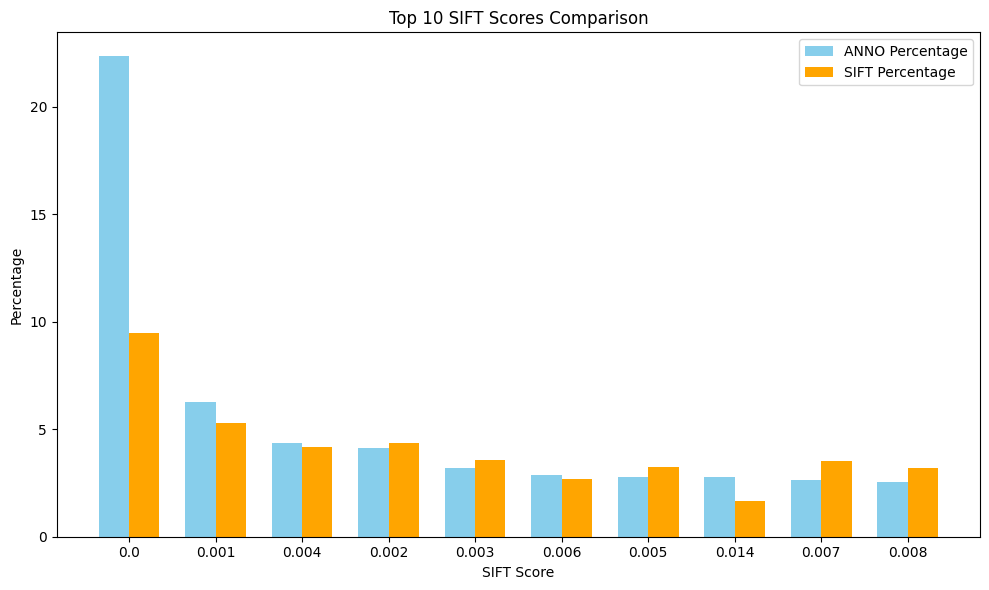

In [ ]:
plt.figure(figsize=(10, 6))

# 막대 그래프 그리기
bar_width = 0.35
index = np.arange(len(top_10_combined))

plt.bar(index, top_10_combined['ANNO_percentage'], bar_width, label='ANNO Percentage', color='skyblue')
plt.bar(index + bar_width, top_10_combined['SIFT_percentage'], bar_width, label='SIFT Percentage', color='orange')

plt.xlabel('SIFT Score')
plt.ylabel('Percentage')
plt.title('Top 10 SIFT Scores Comparison')
plt.xticks(index + bar_width / 2, top_10_combined['SIFT_score'])
plt.legend()

plt.tight_layout()
plt.show()

<ipython-input-7-1e0b0c800aa0>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2_deleterious['SIFT_score'] = pd.to_numeric(df2_deleterious['SIFT_score'], errors='coerce')


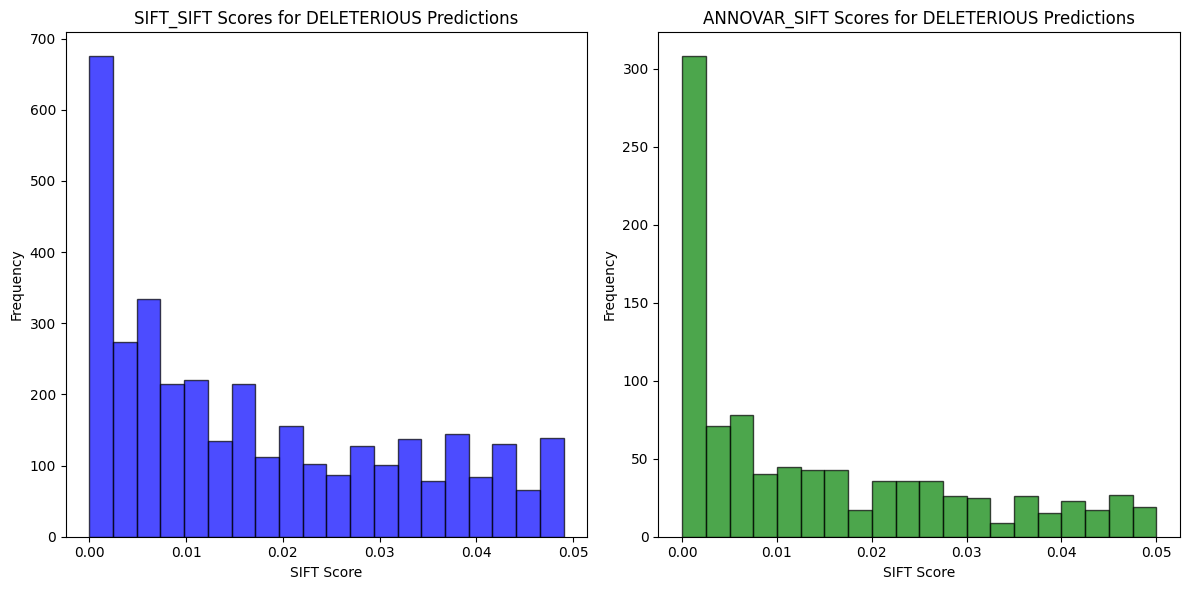

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 첫 번째 Excel 파일 읽기
file_path = 'P1300NJS_F_SIFTannotations.xlsx'
df1 = pd.read_excel(file_path, engine='openpyxl')

# 'SIFT_PREDICTION' 열에서 'DELETERIOUS'인 행만 필터링
deleterious_df1 = df1[df1['SIFT_PREDICTION'] == 'DELETERIOUS']

# 두 번째 CSV 파일 읽기
df2 = pd.read_csv('filtered_annovar_to_sift.csv', sep='\t', on_bad_lines='skip')

# 'SIFT_pred' 열에서 'D' (deleterious)인 행만 필터링
df2_deleterious = df2[df2['SIFT_pred'] == 'D']

# 'SIFT_score' 열을 숫자형으로 변환
df2_deleterious['SIFT_score'] = pd.to_numeric(df2_deleterious['SIFT_score'], errors='coerce')

# NaN 값을 제거한 후 SIFT 점수 추출
sift_scores_df2 = df2_deleterious['SIFT_score'].dropna()


plt.figure(figsize=(12, 6))

# 첫 번째 그래프
plt.subplot(1, 2, 1)
plt.hist(deleterious_df1['SIFT_SCORE'], bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('SIFT_SIFT Scores for DELETERIOUS Predictions')
plt.xlabel('SIFT Score')
plt.ylabel('Frequency')
plt.tight_layout()

# 두 번째 그래프
plt.subplot(1, 2, 2)
plt.hist(sift_scores_df2, bins=20, color='green', edgecolor='black', alpha=0.7)
plt.title('ANNOVAR_SIFT Scores for DELETERIOUS Predictions')
plt.xlabel('SIFT Score')
plt.ylabel('Frequency')
plt.tight_layout()

plt.show()